## Import all data from CSVs into dataframes

In [2]:
# import libraries

import pandas as pd
# set the width of display for dataframes
pd.set_option('display.max_colwidth', 200)
import numpy as np
from functools import reduce
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#### 1) user facts/dates

In [4]:
df_1 = pd.read_csv('../data/raw/retention_user_facts.csv')

In [5]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354503 entries, 0 to 354502
Data columns (total 7 columns):
Users ID                                                354503 non-null int64
Orders Days Between Last Order and Today                352978 non-null float64
User Facts First Download Date                          354503 non-null object
Users Created Date                                      354503 non-null object
User Order Facts First Order Date                       352978 non-null object
User Payment Facts First Payment Date                   352180 non-null object
User Order Days Quarters Ordered Pc Gc In First Year    350372 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 18.9+ MB


In [6]:
# name the columns
df_1.columns=['user_id','days_since_ordered', 'download', 'signup', 'first_order', 'first_payment', 'quarters_first_year']

In [7]:
# change date columns to datetime type
df_1.download = pd.to_datetime(df_1.download)
df_1.signup = pd.to_datetime(df_1.signup)
df_1.first_payment = pd.to_datetime(df_1.first_payment)
df_1.first_order = pd.to_datetime(df_1.first_order)

In [8]:
# calculate days between download, signup, and first order
df_1['days_between_download_signup'] = df_1.signup - df_1.download
df_1['days_between_signup_order'] = df_1.first_order - df_1.signup
df_1['days_between_download_order'] = df_1.first_order - df_1.download

df_1.drop(['download', 'signup', 'first_order', 'first_payment'], inplace=True, axis=1)

In [9]:
# convert timedeltas to ints
df_1['days_between_download_signup'] = df_1['days_between_download_signup'].dt.days
df_1['days_between_signup_order'] = df_1['days_between_signup_order'].dt.days
df_1['days_between_download_order'] = df_1['days_between_download_order'].dt.days

In [10]:
# add retained flag if active in past 365 days
df_1['retained'] = df_1.days_since_ordered.apply(lambda x: 1 if x<366 else 0)

df_1.drop('days_since_ordered', inplace=True, axis=1)

In [11]:
# this column doesn't work how I thought it would, deleting
df_1.drop('quarters_first_year', inplace=True, axis=1)

In [12]:
# drop weird users with wrong order of download, signup, order
df_1 = df_1[(df_1['days_between_download_signup']>=0) &
            (df_1['days_between_signup_order']>=0)]

In [13]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349739 entries, 1525 to 354502
Data columns (total 5 columns):
user_id                         349739 non-null int64
days_between_download_signup    349739 non-null int64
days_between_signup_order       349739 non-null float64
days_between_download_order     349739 non-null float64
retained                        349739 non-null int64
dtypes: float64(2), int64(3)
memory usage: 16.0 MB


#### 2) days ordered and recipients, first 30 days

In [223]:
df_2 = pd.read_csv('../data/raw/retention_user_actions.csv')

In [224]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 657463 entries, 0 to 657462
Data columns (total 6 columns):
Users ID                                     657463 non-null int64
Orders Days Since Signup Tiered              657463 non-null object
Orders Unique number of days user ordered    657463 non-null int64
Order Item Count Recipients                  657463 non-null int64
Order Item GC sent                           657463 non-null int64
Order Item PC sent                           657463 non-null int64
dtypes: int64(5), object(1)
memory usage: 30.1+ MB


In [225]:
df_2.columns = ['user_id', 'days_since_signup', 'days_ordered', 'recipients', 'GCs_sent', 'PCs_sent']

In [226]:
df_2.days_since_signup.unique()

array(['Below 1', '1 to 6', '60 to 89', '90 or Above', '30 to 59',
       '14 to 20', '7 to 13', '21 to 29'], dtype=object)

In [227]:
df_2["days_since_signup"] = df_2["days_since_signup"].astype('category')

df_2["days_since_signup"].cat.categories

Index(['1 to 6', '14 to 20', '21 to 29', '30 to 59', '60 to 89', '7 to 13',
       '90 or Above', 'Below 1'],
      dtype='object')

In [228]:
df_2['cards_sent'] = df_2['GCs_sent'] + df_2['PCs_sent']

In [229]:
# pivot the days_since_signup column
df_2_pivot = df_2.pivot_table(index='user_id', 
                              columns='days_since_signup', 
                              values=['days_ordered', 'recipients', 'cards_sent'], 
                              fill_value=0)

df_2_pivot.columns = ['_'.join(col) for col in df_2_pivot.columns.values]

df_2_pivot.reset_index(level=0, inplace=True)

In [230]:
# combine week 1 orders
df_2_pivot['days_ordered_0 to 6'] = df_2_pivot['days_ordered_Below 1'] + df_2_pivot['days_ordered_1 to 6']
df_2_pivot['recipients_0 to 6'] = df_2_pivot['recipients_Below 1'] + df_2_pivot['recipients_1 to 6']
df_2_pivot['cards_sent_0 to 6'] = df_2_pivot['cards_sent_Below 1'] + df_2_pivot['cards_sent_1 to 6']

In [231]:
df_2_pivot.drop(['days_ordered_Below 1', 'days_ordered_1 to 6', 
                 'recipients_Below 1', 'recipients_1 to 6',
                'cards_sent_Below 1', 'cards_sent_1 to 6'], 
                axis=1, inplace=True)

In [232]:
df_2_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349960 entries, 0 to 349959
Data columns (total 22 columns):
user_id                     349960 non-null int64
cards_sent_14 to 20         349960 non-null int64
cards_sent_21 to 29         349960 non-null int64
cards_sent_30 to 59         349960 non-null int64
cards_sent_60 to 89         349960 non-null int64
cards_sent_7 to 13          349960 non-null int64
cards_sent_90 or Above      349960 non-null int64
days_ordered_14 to 20       349960 non-null int64
days_ordered_21 to 29       349960 non-null int64
days_ordered_30 to 59       349960 non-null int64
days_ordered_60 to 89       349960 non-null int64
days_ordered_7 to 13        349960 non-null int64
days_ordered_90 or Above    349960 non-null int64
recipients_14 to 20         349960 non-null int64
recipients_21 to 29         349960 non-null int64
recipients_30 to 59         349960 non-null int64
recipients_60 to 89         349960 non-null int64
recipients_7 to 13          349960 non-

#### 3) count orders and items by day, first 30 days

In [25]:
df_3 = pd.read_csv('../data/raw/retention_count_items_orders_30_days.csv')

In [26]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583431 entries, 0 to 583430
Data columns (total 4 columns):
Users ID                       583431 non-null int64
Orders Days Since Signup       583431 non-null int64
Order Item Order Item Count    583431 non-null int64
Order Item Count Orders        583431 non-null int64
dtypes: int64(4)
memory usage: 17.8 MB


In [27]:
# rename cols, pivot
df_3.columns = ['user_id', 'days_since_signup', 'items', 'orders']

df_3_pivot = df_3.pivot_table(index='user_id', columns='days_since_signup', values=['items', 'orders'], fill_value=0)

df_3_pivot.columns = [i[0] + '_day' + str(i[1]) for i in df_3_pivot.columns.values]

df_3_pivot.reset_index(level=0, inplace=True)

In [28]:
df_3_pivot['orders_days_0 to 6'] = (df_3_pivot['orders_day0'] + df_3_pivot['orders_day1'] + 
                                       df_3_pivot['orders_day2'] + df_3_pivot['orders_day3'] + 
                                       df_3_pivot['orders_day4'] + df_3_pivot['orders_day5'] +
                                       df_3_pivot['orders_day6'])

In [29]:
df_3_pivot['items_days_0 to 6'] = (df_3_pivot['items_day0'] + df_3_pivot['items_day1'] + 
                                       df_3_pivot['items_day2'] + df_3_pivot['items_day3'] + 
                                       df_3_pivot['items_day4'] + df_3_pivot['items_day5'] +
                                       df_3_pivot['items_day6'])

In [30]:
df_3_selected = df_3_pivot[['user_id', 'orders_days_0 to 6', 'items_days_0 to 6']]

In [31]:
df_3_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331579 entries, 0 to 331578
Data columns (total 3 columns):
user_id               331579 non-null int64
orders_days_0 to 6    331579 non-null int64
items_days_0 to 6     331579 non-null int64
dtypes: int64(3)
memory usage: 7.6 MB


#### 4) use cases

In [32]:
df_4 = pd.read_csv('../data/raw/first_main_count_use_cases.csv')

In [33]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533760 entries, 0 to 533759
Data columns (total 4 columns):
Use Cases User ID                533760 non-null int64
Use Cases First Use Case         533760 non-null object
Use Cases Main Use Case          533760 non-null object
Use Cases Number of Use Cases    533760 non-null int64
dtypes: int64(2), object(2)
memory usage: 16.3+ MB


In [34]:
df_4.columns = ['user_id', 'first_use_case', 'main_use_case', 'number_of_use_cases']

#### 5) days ordered by month, first year

In [35]:
df_5 = pd.read_csv('../data/raw/retention_orders_first_year.csv')

In [36]:
df_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839228 entries, 0 to 839227
Data columns (total 3 columns):
Users ID                                     839228 non-null int64
Orders Days Since User Tiered Monthly        839228 non-null object
Orders Unique number of days user ordered    839228 non-null int64
dtypes: int64(2), object(1)
memory usage: 19.2+ MB


In [37]:
df_5.columns=['user_id','days_since_user', 'days_ordered']

In [38]:
df_5.days_since_user.unique()

array(['330 to 365', 'Below 30', '300 to 329', '90 to 119', '60 to 89',
       '180 to 209', '120 to 149', '30 to 59', '240 to 269', '210 to 239',
       '270 to 299', '150 to 179', '366 to 729', '730 or Above'],
      dtype=object)

In [39]:
# keep first year only
df_5 = df_5[df_5.days_since_user.isin(['330 to 365', 'Below 30', '300 to 329', '90 to 119', '60 to 89',
       '180 to 209', '120 to 149', '30 to 59', '240 to 269', '210 to 239',
       '270 to 299', '150 to 179'])]

In [40]:
df_5.days_since_user = df_5.days_since_user.astype('category')

df_5_pivot = df_5.pivot_table(index='user_id', columns='days_since_user', values=['days_ordered'], fill_value=0)

df_5_pivot.columns = ['_'.join(col) for col in df_5_pivot.columns.values]

df_5_pivot.reset_index(level=0, inplace=True)

In [41]:
df_5_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358680 entries, 0 to 358679
Data columns (total 13 columns):
user_id                    358680 non-null int64
days_ordered_120 to 149    358680 non-null int64
days_ordered_150 to 179    358680 non-null int64
days_ordered_180 to 209    358680 non-null int64
days_ordered_210 to 239    358680 non-null int64
days_ordered_240 to 269    358680 non-null int64
days_ordered_270 to 299    358680 non-null int64
days_ordered_30 to 59      358680 non-null int64
days_ordered_300 to 329    358680 non-null int64
days_ordered_330 to 365    358680 non-null int64
days_ordered_60 to 89      358680 non-null int64
days_ordered_90 to 119     358680 non-null int64
days_ordered_Below 30      358680 non-null int64
dtypes: int64(13)
memory usage: 35.6 MB


In [42]:
# define function to check if a value is zero and return a Boolean as an int (will return 1 if x is not zero, 0 if x is 0)

def nonzero(x):
    return int(x>0)

In [43]:
# get days ordered in each quarter
df_5_pivot['days_ordered_Q1'] = df_5_pivot.apply(lambda x: x['days_ordered_Below 30']+
                                                 x['days_ordered_30 to 59']+
                                                 x['days_ordered_60 to 89'], axis=1)
df_5_pivot['days_ordered_Q2'] = df_5_pivot.apply(lambda x: x['days_ordered_90 to 119']+
                                                 x['days_ordered_120 to 149']+
                                                 x['days_ordered_150 to 179'], axis=1)
df_5_pivot['days_ordered_Q3'] = df_5_pivot.apply(lambda x: x['days_ordered_180 to 209']+
                                                 x['days_ordered_210 to 239']+
                                                 x['days_ordered_240 to 269'], axis=1)
df_5_pivot['days_ordered_Q4'] = df_5_pivot.apply(lambda x: x['days_ordered_270 to 299']+
                                                 x['days_ordered_300 to 329']+
                                                 x['days_ordered_330 to 365'], axis=1)

# get quarters ordered in first year
df_5_pivot['quarters_ordered_first_year'] = df_5_pivot.apply(lambda x: 
                                                     nonzero(x['days_ordered_Q1']) + 
                                                     nonzero(x['days_ordered_Q2']) + 
                                                     nonzero(x['days_ordered_Q3']) + 
                                                     nonzero(x['days_ordered_Q4']), axis=1)

#### 6) credits ordered, first 6 months since signup

In [249]:
df_6 = pd.read_csv('../data/raw/credits_bought_since_signup.csv')

In [250]:
df_6.head()

Users ID Credit Log Days Since Signup Tiered  Credit Log Sum Credits
0  40152532                           90 to 179                     397
1  39797457                            21 to 29                     394
2  39827081                           90 to 179                     390
3  40412797                           90 to 179                     390
4  39739582                            30 to 59                     388

In [251]:
df_6.columns = ['user_id', 'days_since_signup', 'credits_bought']

In [252]:
# drop extreme values
df_6 = df_6[df_6['credits_bought']<201]

In [253]:
df_6.describe()

user_id  credits_bought
count  8.216750e+05   821675.000000
mean   4.135135e+07        4.608884
std    1.382303e+07        8.837088
min    3.000000e+00        0.000000
25%    3.967384e+07        0.000000
50%    3.988292e+07        1.000000
75%    4.025942e+07        5.000000
max    1.800175e+08      200.000000

In [254]:
df_6_pivot = df_6.pivot_table(index='user_id', columns='days_since_signup', values=['credits_bought'], fill_value=0)

df_6_pivot.columns = ['_'.join(col) for col in df_6_pivot.columns.values]

df_6_pivot.reset_index(level=0, inplace=True)

In [255]:
df_6_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357449 entries, 0 to 357448
Data columns (total 10 columns):
user_id                        357449 non-null int64
credits_bought_1 to 6          357449 non-null int64
credits_bought_14 to 20        357449 non-null int64
credits_bought_180 or Above    357449 non-null int64
credits_bought_21 to 29        357449 non-null int64
credits_bought_30 to 59        357449 non-null int64
credits_bought_60 to 89        357449 non-null int64
credits_bought_7 to 13         357449 non-null int64
credits_bought_90 to 179       357449 non-null int64
credits_bought_Below 1         357449 non-null int64
dtypes: int64(10)
memory usage: 27.3 MB


In [256]:
df_6_pivot['credits_bought_0 to 6'] = df_6_pivot['credits_bought_Below 1'] + df_6_pivot['credits_bought_1 to 6']

In [257]:
df_6_pivot.drop(['credits_bought_180 or Above', 'credits_bought_Below 1', 'credits_bought_1 to 6'], inplace=True, axis=1)

#### 7) count orders and days ordered in first year since signup

In [52]:
df_7 = pd.read_csv('../data/raw/year_total_orders_days.csv')

In [53]:
df_7.head()

Users ID  Orders Unique number of days user ordered  Orders Count
0  180017469                                          4             5
1  180017461                                          2             2
2  180014749                                          1             1
3  180014747                                          1             1
4  180014745                                          3             5

In [54]:
df_7.columns= ['user_id', 'days_ordered_year1', 'orders_year1']

In [55]:
df_7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358680 entries, 0 to 358679
Data columns (total 3 columns):
user_id               358680 non-null int64
days_ordered_year1    358680 non-null int64
orders_year1          358680 non-null int64
dtypes: int64(3)
memory usage: 8.2 MB


In [56]:
df_7 = df_7[df_7.orders_year1<60]

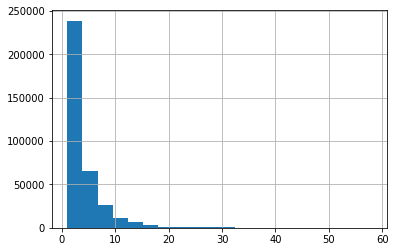

In [57]:
df_7['days_ordered_year1'].hist(bins=20)

In [58]:
df_7.describe()

user_id  days_ordered_year1   orders_year1
count  3.566830e+05       356683.000000  356683.000000
mean   4.154144e+07            3.665148       5.717452
std    1.474144e+07            4.131650       7.328238
min    3.946816e+07            1.000000       1.000000
25%    3.967313e+07            1.000000       1.000000
50%    3.987853e+07            2.000000       3.000000
75%    4.026110e+07            4.000000       7.000000
max    1.800175e+08           58.000000      59.000000

In [59]:
len(df_7[df_7['orders_year1']==1])

100745

## Merge all dataframes

In [60]:
df_1.columns

Index(['user_id', 'days_between_download_signup', 'days_between_signup_order',
       'days_between_download_order', 'retained'],
      dtype='object')

In [61]:
df_2_pivot.columns

Index(['user_id', 'days_ordered_14 to 20', 'days_ordered_21 to 29',
       'days_ordered_7 to 13', 'recipients_14 to 20', 'recipients_21 to 29',
       'recipients_7 to 13', 'days_ordered_0 to 6', 'recipients_0 to 6'],
      dtype='object')

In [62]:
df_3_selected.columns

Index(['user_id', 'orders_days_0 to 6', 'items_days_0 to 6'], dtype='object')

In [63]:
df_4.columns

Index(['user_id', 'first_use_case', 'main_use_case', 'number_of_use_cases'], dtype='object')

In [64]:
df_5_pivot.columns

Index(['user_id', 'days_ordered_120 to 149', 'days_ordered_150 to 179',
       'days_ordered_180 to 209', 'days_ordered_210 to 239',
       'days_ordered_240 to 269', 'days_ordered_270 to 299',
       'days_ordered_30 to 59', 'days_ordered_300 to 329',
       'days_ordered_330 to 365', 'days_ordered_60 to 89',
       'days_ordered_90 to 119', 'days_ordered_Below 30', 'days_ordered_Q1',
       'days_ordered_Q2', 'days_ordered_Q3', 'days_ordered_Q4',
       'quarters_ordered_first_year'],
      dtype='object')

In [65]:
df_6_pivot.columns

Index(['user_id', 'credits_bought_1 to 6', 'credits_bought_14 to 20',
       'credits_bought_21 to 29', 'credits_bought_30 to 59',
       'credits_bought_60 to 89', 'credits_bought_7 to 13',
       'credits_bought_90 to 179', 'credits_bought_Below 1'],
      dtype='object')

In [66]:
df_7.columns

Index(['user_id', 'days_ordered_year1', 'orders_year1'], dtype='object')

## merge dataframes on user_id 

In [67]:
data_frames = [df_1, df_2_pivot, df_3_selected, df_4, df_5_pivot, df_6_pivot, df_7]

df_all = reduce(lambda left, right: pd.merge(left, right, on=['user_id'],
                                            how='inner'), data_frames)

In [68]:
df_all.dropna(inplace=True)

In [69]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216439 entries, 0 to 216438
Data columns (total 45 columns):
user_id                         216439 non-null int64
days_between_download_signup    216439 non-null int64
days_between_signup_order       216439 non-null float64
days_between_download_order     216439 non-null float64
retained                        216439 non-null int64
days_ordered_14 to 20           216439 non-null int64
days_ordered_21 to 29           216439 non-null int64
days_ordered_7 to 13            216439 non-null int64
recipients_14 to 20             216439 non-null int64
recipients_21 to 29             216439 non-null int64
recipients_7 to 13              216439 non-null int64
days_ordered_0 to 6             216439 non-null int64
recipients_0 to 6               216439 non-null int64
orders_days_0 to 6              216439 non-null int64
items_days_0 to 6               216439 non-null int64
first_use_case                  216439 non-null object
main_use_case       

In [70]:
df_all['retained'].value_counts()

0    112033
1    104406
Name: retained, dtype: int64

In [71]:
df_all.describe().T

count          mean           std  \
user_id                       216439.0  4.226467e+07  1.726926e+07   
days_between_download_signup  216439.0  6.781315e+00  3.337928e+01   
days_between_signup_order     216439.0  2.149964e+00  6.146927e+00   
days_between_download_order   216439.0  8.931279e+00  3.379233e+01   
retained                      216439.0  4.823807e-01  4.996906e-01   
days_ordered_14 to 20         216439.0  2.002735e-01  5.215034e-01   
days_ordered_21 to 29         216439.0  2.041222e-01  5.372489e-01   
days_ordered_7 to 13          216439.0  2.709863e-01  6.095967e-01   
recipients_14 to 20           216439.0  3.399711e-01  1.385781e+00   
recipients_21 to 29           216439.0  3.368709e-01  1.340831e+00   
recipients_7 to 13            216439.0  4.647961e-01  1.523697e+00   
days_ordered_0 to 6           216439.0  1.139582e+00  7.171859e-01   
recipients_0 to 6             216439.0  1.917898e+00  2.659325e+00   
orders_days_0 to 6            216439.0  1.760473e+00  1.962534e+00   
items_days_0 to 6             216439.0  1.917871e+00  2.659325e+00   
number_of_use_cases           216439.0  2.046429e+00  1.173943e+00   
days_ordered_120 to 149       216439.0  2.267336e-01  6.432270e-01   
days_ordered_150 to 179       216439.0  2.001026e-01  5.998224e-01   
days_ordered_180 to 209       216439.0  1.860386e-01  5.761205e-01   
days_ordered_210 to 239       216439.0  1.759618e-01  5.607113e-01   
days_ordered_240 to 269       216439.0  1.686249e-01  5.520719e-01   
days_ordered_270 to 299       216439.0  1.585389e-01  5.323071e-01   
days_ordered_30 to 59         216439.0  3.954463e-01  8.785922e-01   
days_ordered_300 to 329       216439.0  1.570281e-01  5.319172e-01   
days_ordered_330 to 365       216439.0  2.231622e-01  6.777306e-01   
days_ordered_60 to 89         216439.0  2.940921e-01  7.354208e-01   
days_ordered_90 to 119        216439.0  2.520202e-01  6.759422e-01   
days_ordered_Below 30         216439.0  1.857304e+00  1.399273e+00   
days_ordered_Q1               216439.0  2.546842e+00  2.235075e+00   
days_ordered_Q2               216439.0  6.788564e-01  1.397062e+00   
days_ordered_Q3               216439.0  5.306253e-01  1.223080e+00   
days_ordered_Q4               216439.0  5.387292e-01  1.240522e+00   
quarters_ordered_first_year   216439.0  1.862118e+00  9.994782e-01   
credits_bought_1 to 6         216439.0  1.125550e+00  4.500306e+00   
credits_bought_14 to 20       216439.0  4.536243e-01  3.019305e+00   
credits_bought_21 to 29       216439.0  4.356701e-01  2.956890e+00   
credits_bought_30 to 59       216439.0  8.337314e-01  4.207560e+00   
credits_bought_60 to 89       216439.0  6.496380e-01  3.814241e+00   
credits_bought_7 to 13        216439.0  6.130134e-01  3.366044e+00   
credits_bought_90 to 179      216439.0  1.734900e+00  6.694118e+00   
credits_bought_Below 1        216439.0  5.424249e+00  7.748205e+00   
days_ordered_year1            216439.0  4.295053e+00  4.564508e+00   
orders_year1                  216439.0  6.625885e+00  7.933662e+00   

                                     min         25%         50%         75%  \
user_id                       39468202.0  39780158.0  40061014.0  40420493.0   
days_between_download_signup         0.0         0.0         0.0         0.0   
days_between_signup_order            0.0         0.0         0.0         1.0   
days_between_download_order          0.0         0.0         0.0         4.0   
retained                             0.0         0.0         0.0         1.0   
days_ordered_14 to 20                0.0         0.0         0.0         0.0   
days_ordered_21 to 29                0.0         0.0         0.0         0.0   
days_ordered_7 to 13                 0.0         0.0         0.0         0.0   
recipients_14 to 20                  0.0         0.0         0.0         0.0   
recipients_21 to 29                  0.0         0.0         0.0         0.0   
recipients_7 to 13                   0.0         0.0         0.0        

In [72]:
# shouldn't have any where # of use cases is 0
df_all = df_all[df_all.number_of_use_cases>0]

In [73]:
skewed_cols = (['days_between_download_signup', 'days_between_signup_order',
       'days_between_download_order', 'recipients_14 to 20',
       'recipients_21 to 29', 'recipients_7 to 13', 
       'recipients_0 to 6', 'orders_days_0 to 6', 'items_days_0 to 6',
               'credits_bought_1 to 6', 'credits_bought_14 to 20',
       'credits_bought_21 to 29', 'credits_bought_30 to 59',
       'credits_bought_60 to 89', 'credits_bought_7 to 13',
       'credits_bought_90 to 179', 'credits_bought_Below 1',
               'days_ordered_year1', 'orders_year1'])

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


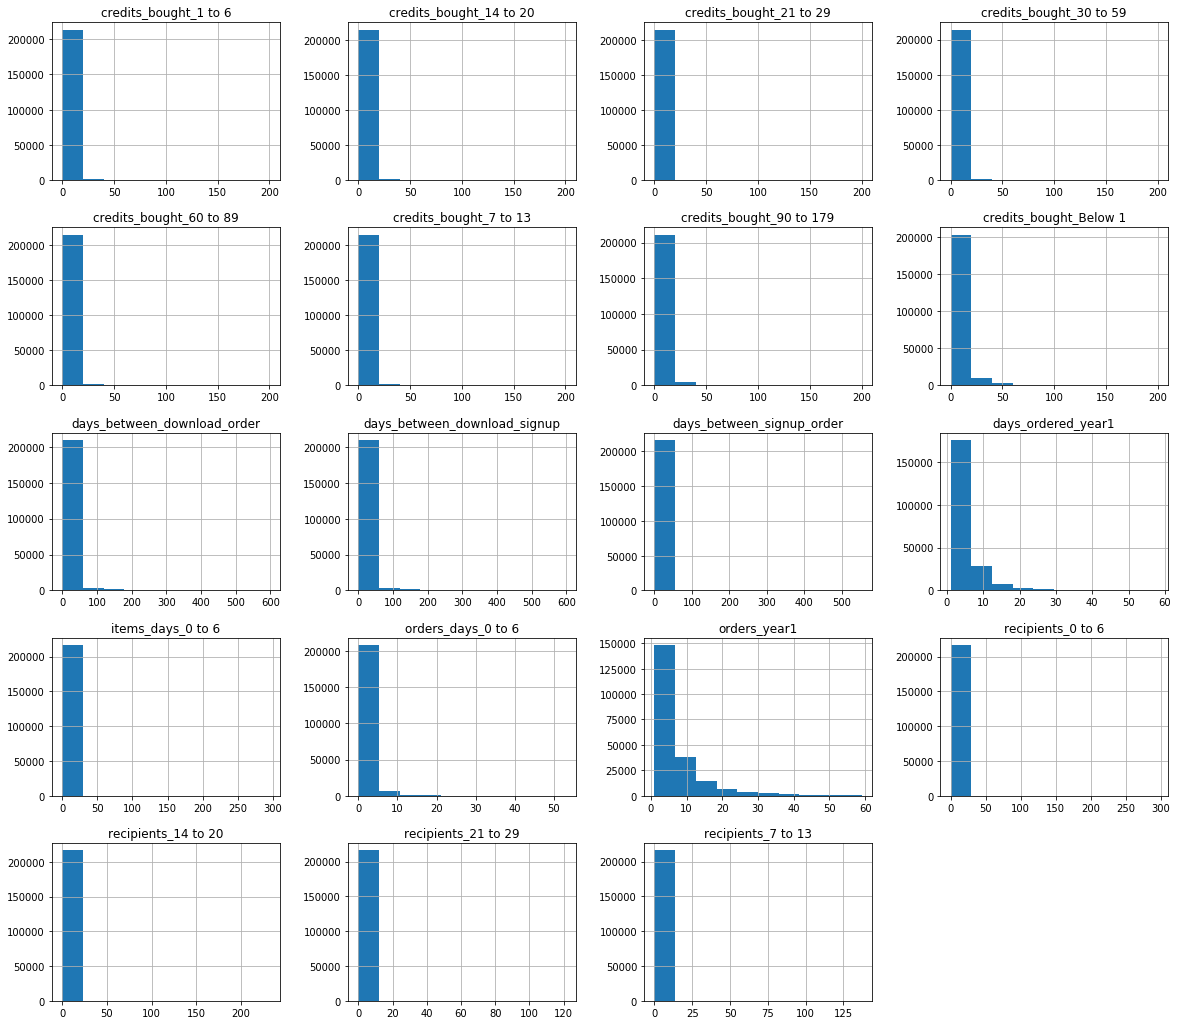

In [74]:
# check dist.s for outliers/skew
fig = plt.figure(figsize = (20,18))
ax = fig.gca()
df_all[skewed_cols].hist(ax=ax)
fig.show()

In [75]:
# remove outliers

df_all = df_all[(df_all['recipients_0 to 6']<30) &
               (df_all['recipients_7 to 13']<30) &
               (df_all['recipients_14 to 20']<30) &
               (df_all['recipients_21 to 29']<30)]

In [76]:
df_all[skewed_cols].describe().T

count      mean        std  min  25%  50%  \
days_between_download_signup  216016.0  6.784706  33.396321  0.0  0.0  0.0   
days_between_signup_order     216016.0  2.147035   6.144926  0.0  0.0  0.0   
days_between_download_order   216016.0  8.931741  33.808470  0.0  0.0  0.0   
recipients_14 to 20           216016.0  0.330374   1.147091  0.0  0.0  0.0   
recipients_21 to 29           216016.0  0.325240   1.123041  0.0  0.0  0.0   
recipients_7 to 13            216016.0  0.454753   1.357544  0.0  0.0  0.0   
recipients_0 to 6             216016.0  1.878597   2.147656  0.0  1.0  1.0   
orders_days_0 to 6            216016.0  1.750671   1.882755  0.0  1.0  1.0   
items_days_0 to 6             216016.0  1.878569   2.147657  0.0  1.0  1.0   
credits_bought_1 to 6         216016.0  1.099372   4.304230  0.0  0.0  0.0   
credits_bought_14 to 20       216016.0  0.444884   2.923283  0.0  0.0  0.0   
credits_bought_21 to 29       216016.0  0.423237   2.810561  0.0  0.0  0.0   
credits_bought_30 to 59       216016.0  0.828943   4.159668  0.0  0.0  0.0   
credits_bought_60 to 89       216016.0  0.647133   3.782044  0.0  0.0  0.0   
credits_bought_7 to 13        216016.0  0.601733   3.222715  0.0  0.0  0.0   
credits_bought_90 to 179      216016.0  1.727585   6.635549  0.0  0.0  0.0   
credits_bought_Below 1        216016.0  5.397188   7.640575  0.0  1.0  5.0   
days_ordered_year1            216016.0  4.293955   4.563687  1.0  1.0  3.0   
orders_year1                  216016.0  6.607960   7.892561  1.0  2.0  4.0   

                              75%    max  
days_between_download_signup  0.0  597.0  
days_between_signup_order     1.0  553.0  
days_between_download_order   4.0  597.0  
recipients_14 to 20           0.0   28.0  
recipients_21 to 29           0.0   29.0  
recipients_7 to 13            0.0   29.0  
recipients_0 to 6             2.0   29.0  
orders_days_0 to 6            2.0   29.0  
items_days_0 to 6             2.0   29.0  
credits_bought_1 to 6         0.0  200.0  
credits_bought_14 to 20       0.0  200.0  
credits_bought_21 to 29       0.0  200.0  
credits_bought_30 to 59       0.0  200.0  
credits_bought_60 to 89       0.0  200.0  
credits_bought_7 to 13        0.0  126.0  
credits_bought_90 to 179      0.0  200.0  
credits_bought_Below 1        6.0  200.0  
days_ordered_year1            5.0   58.0  
orders_year1                  8.0   59.0

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


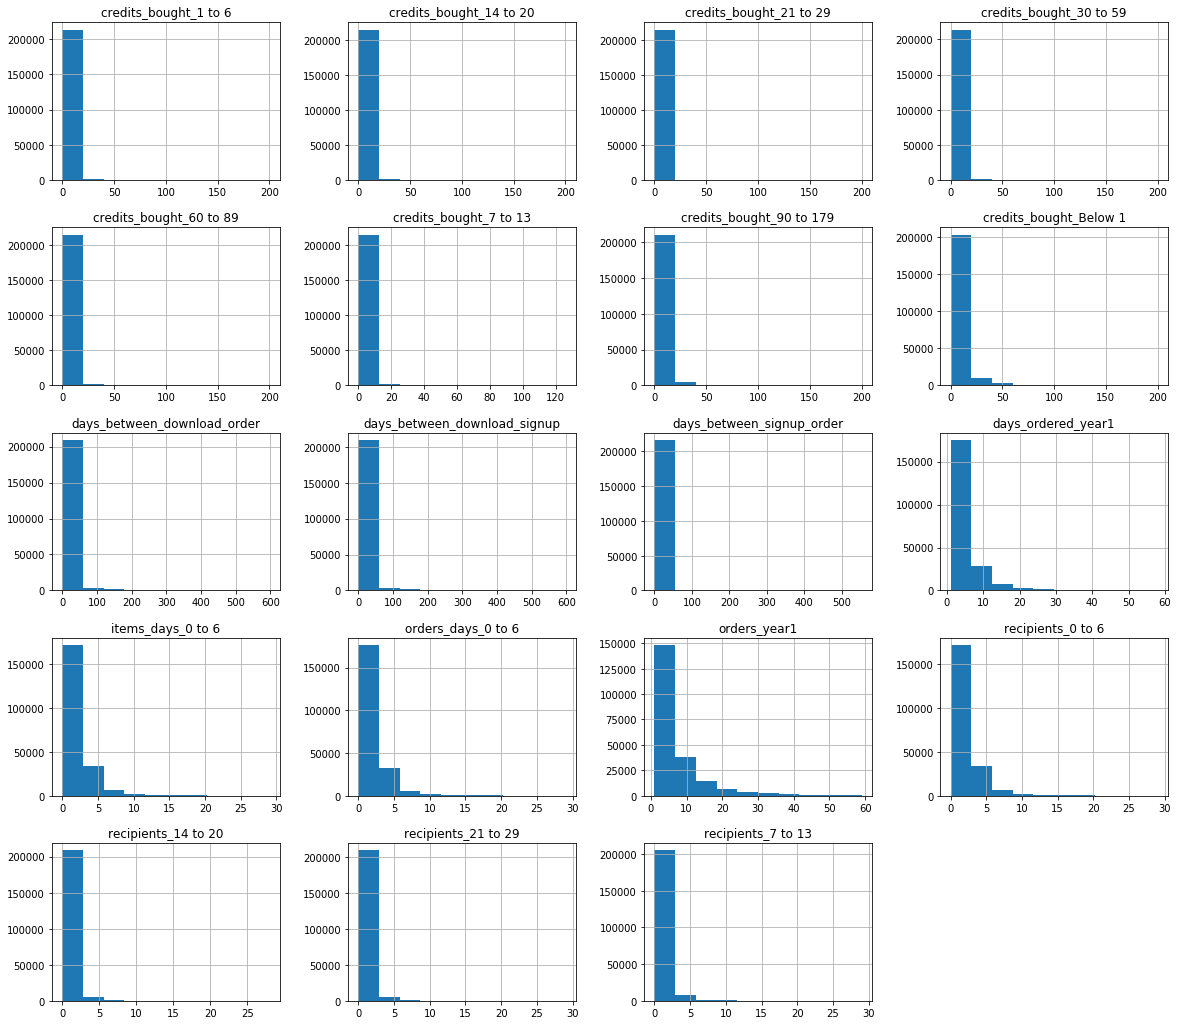

In [77]:
# check dist.s for outliers/skew, again
fig = plt.figure(figsize = (20,18))
ax = fig.gca()
df_all[skewed_cols].hist(ax=ax)
fig.show()

In [78]:
# try robust scaler
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

df_all[skewed_cols] = scaler.fit_transform(df_all[skewed_cols])

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


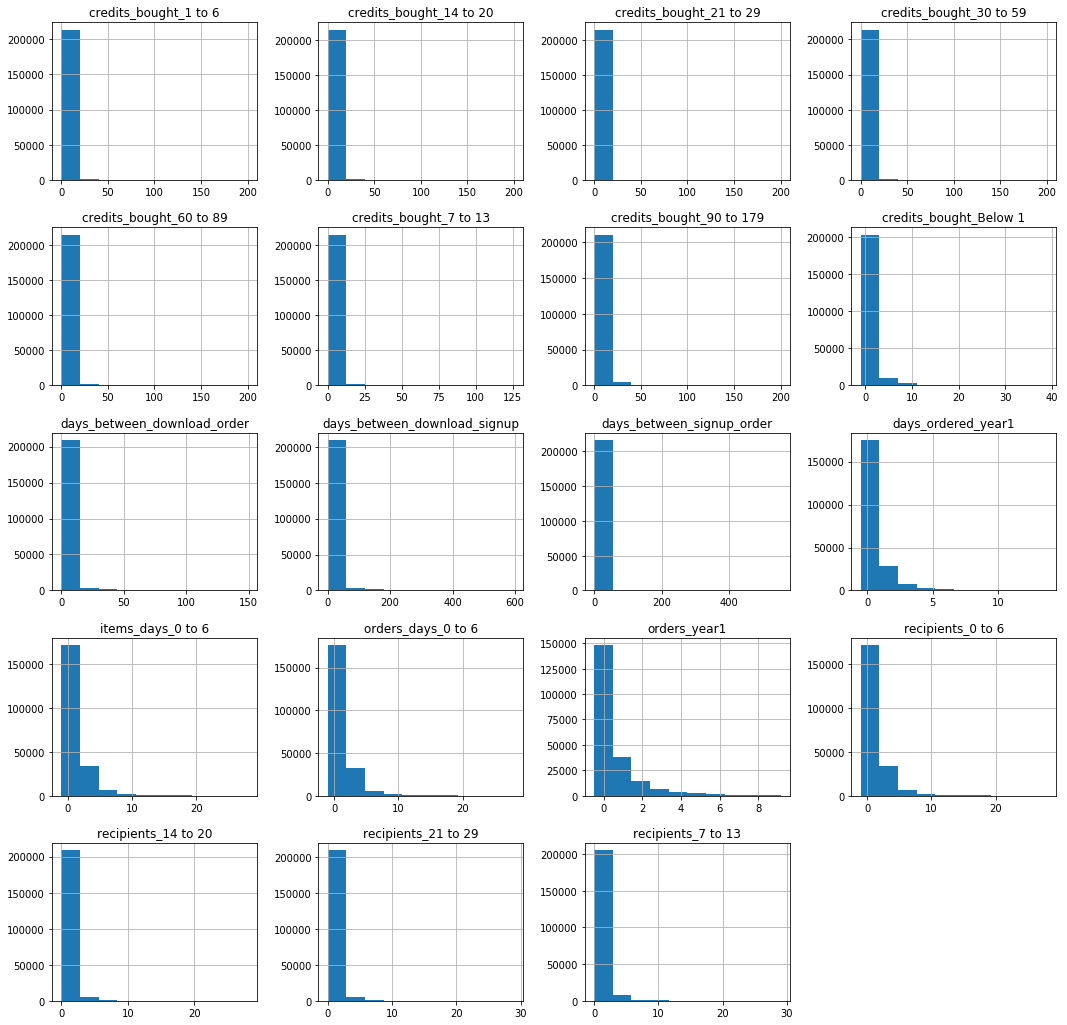

In [79]:
# check dist.s for outliers/skew, after transforming
fig = plt.figure(figsize = (18,18))
ax = fig.gca()
df_all[skewed_cols].hist(ax=ax)
fig.show()

In [80]:
# still skewed...not sure why that didn't seem to do anything
# doesn't matter for just checking individual correlations but would impact a linear model

## Correlation analysis

#### 1) Habit Moment: Find features that are correlated with retained 

In [81]:
# check correlations with retention (to find habit moment)
df_all.corr().iloc[:,4:5].sort_values(by='retained',ascending=False)

retained
retained                      1.000000
quarters_ordered_first_year   0.609431
number_of_use_cases           0.515759
days_ordered_year1            0.446358
orders_year1                  0.414203
days_ordered_Q4               0.368331
days_ordered_Q3               0.353072
days_ordered_Q2               0.344455
days_ordered_Q1               0.298840
days_ordered_330 to 365       0.275369
days_ordered_150 to 179       0.256872
days_ordered_240 to 269       0.256723
days_ordered_210 to 239       0.256508
days_ordered_300 to 329       0.254249
days_ordered_180 to 209       0.253866
days_ordered_120 to 149       0.253783
days_ordered_270 to 299       0.253713
days_ordered_90 to 119        0.242525
days_ordered_60 to 89         0.232703
days_ordered_30 to 59         0.223133
days_ordered_Below 30         0.214812
credits_bought_90 to 179      0.198693
days_ordered_21 to 29         0.142586
days_ordered_14 to 20         0.129121
days_ordered_7 to 13          0.129013
credits_bought_Below 1        0.123193
recipients_21 to 29           0.111291
credits_bought_60 to 89       0.110229
credits_bought_30 to 59       0.108707
recipients_7 to 13            0.098102
recipients_14 to 20           0.097819
orders_days_0 to 6            0.094106
items_days_0 to 6             0.085811
recipients_0 to 6             0.085807
days_ordered_0 to 6           0.083519
credits_bought_21 to 29       0.061428
credits_bought_1 to 6         0.056929
credits_bought_14 to 20       0.056773
credits_bought_7 to 13        0.054410
days_between_signup_order     0.027679
days_between_download_order   0.022189
days_between_download_signup  0.017370
user_id                      -0.027332

In [82]:
# highest correlation with 'retained' is quarters_ordered_first_year, number of use cases

In [413]:
# select just the variables of interest
df_habit = df_all[['user_id', 'retained', 'first_use_case', 'quarters_ordered_first_year', 
                   'number_of_use_cases']]

In [414]:
# look at correlation matrix/heatmap to see collinearity

corr = df_habit.corr().iloc[1:,1:]

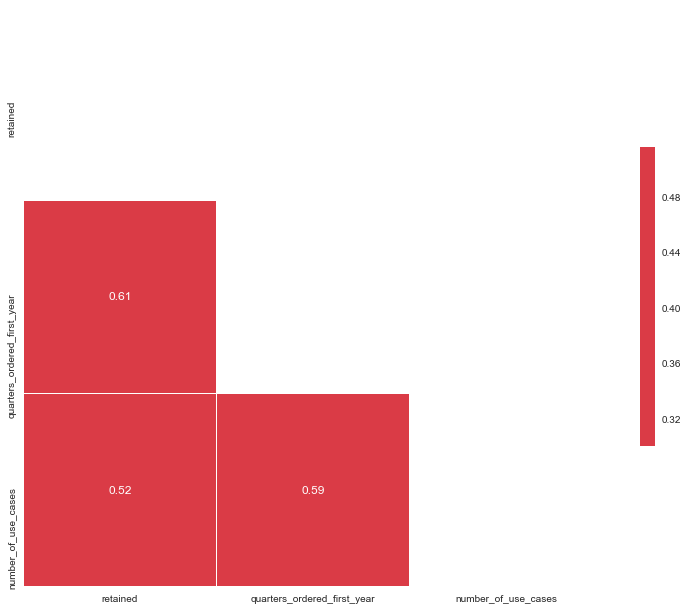

In [415]:
sns.set(style="white")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(13, 11))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [86]:
# this shows us that 'quarters_ordered_first_year' and 'number_of_use_cases' have collinearity with each other
# we would need to address this before building a linear model

In [416]:
# get dummy variables 
df_habit_dummies = pd.get_dummies(df_habit, columns=['quarters_ordered_first_year', 'number_of_use_cases'])

In [417]:
df_habit_dummies.corr().iloc[2:,1:2].sort_values(by='retained', ascending=False)

retained
quarters_ordered_first_year_3  0.322504
quarters_ordered_first_year_4  0.294621
quarters_ordered_first_year_2  0.263140
number_of_use_cases_3          0.253630
number_of_use_cases_4          0.246367
number_of_use_cases_5          0.179035
number_of_use_cases_6          0.093890
number_of_use_cases_2          0.082296
number_of_use_cases_1         -0.487612
quarters_ordered_first_year_1 -0.639612

In [90]:
# check avg and counts for each number of use cases
df_all.groupby('number_of_use_cases').mean()[['retained', 'quarters_ordered_first_year']]

retained  quarters_ordered_first_year
number_of_use_cases                                       
1                    0.198620                     1.324968
2                    0.547912                     1.842792
3                    0.767108                     2.367040
4                    0.891859                     2.891301
5                    0.953820                     3.285201
6                    0.975270                     3.574446

In [92]:
df_all.groupby('number_of_use_cases').count().iloc[:,0:1]

user_id
number_of_use_cases         
1                      91612
2                      61269
3                      35759
4                      17921
5                       7514
6                       1941

In [150]:
use_cases = ['just_because', 'thank_you', 'traveling', 'birthday', 'parenting', 'holidays']

In [424]:
# get correlations with retention by use case

correl = df_habit_dummies.corr()

# make dataframe of correlation coefficients
retention_corrs = pd.DataFrame(data=correl[2:]['retained']).rename(columns={'retained':'all users'})

# add other use cases to dataframe and get correlations with retained
for uc in use_cases:
    retention_corrs[uc] = df_habit_dummies[df_habit_dummies['first_use_case']==uc].corr()[1:]['retained']

retention_corrs.round(2).style.highlight_max()

#### this shows us that quarters_ordered_first_year_3 and sometimes 4 has the highest correlation with retained
 - number_of_use_cases_3, sometimes 4, has a lower correlation with retained
 - number_of_use_cases_1 and quarters_ordered_first_year_1 are highly negatively correlated with retained
 -  means that it's really important to get users to at least 3 of each!

In [422]:
retention_corrs.to_csv('retention_corrs_by_use_case.csv')

#### 2) Aha moment - correlated with habit moment (quarters_ordered_first_year_3 or 4 and number_of_use_cases_3 or 4)

In [450]:
df_aha = pd.get_dummies(df_all, columns=['quarters_ordered_first_year', 'number_of_use_cases'])

In [433]:
df_aha.head()

user_id  days_between_download_signup  days_between_signup_order  \
0  40779666                           0.0                        1.0   
1  40779742                           7.0                        0.0   
2  40779790                          93.0                        0.0   
3  40779730                           8.0                        1.0   
4  40779784                           0.0                        0.0   

   days_between_download_order  retained  days_ordered_14 to 20  \
0                         0.25         1                      0   
1                         1.75         0                      0   
2                        23.25         0                      0   
3                         2.25         0                      0   
4                         0.00         1                      2   

   days_ordered_21 to 29  days_ordered_7 to 13  recipients_14 to 20  \
0                      1                     0                  0.0   
1                      0                     0                  0.0   
2                      0                     0                  0.0   
3                      0                     0                  0.0   
4                      0                     1                  5.0   

   recipients_21 to 29          ...            quarters_ordered_first_year_1  \
0                  1.0          ...                                        0   
1                  0.0          ...                                        1   
2                  0.0          ...                                        1   
3                  0.0          ...                                        1   
4                  0.0          ...                                        1   

   quarters_ordered_first_year_2  quarters_ordered_first_year_3  \
0                              1                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   

   quarters_ordered_first_year_4  number_of_use_cases_1 number_of_use_cases_2  \
0                              0                      0                     0   
1                              0                      1                     0   
2                              0                      0                     1   
3                              0                      1                     0   
4                              0                      0                     1   

  number_of_use_cases_3  number_of_use_cases_4  number_of_use_cases_5  \
0                     0                      1                      0   
1                     0                      0                      0   
2                     0                      0                      0   
3                     0                      0                      0   
4                     0                      0                      0   

   number_of_use_cases_6  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  

[5 rows x 53 columns]

In [434]:
# check for correlations with habit moments
df_aha[['quarters_ordered_first_year_3', 'quarters_ordered_first_year_4', 
        'number_of_use_cases_3', 'number_of_use_cases_4',
        'days_ordered_14 to 20',
       'days_ordered_21 to 29', 'days_ordered_7 to 13', 'days_ordered_0 to 6',
       'days_ordered_Below 30', 'days_ordered_Q1']].corr().iloc[4:,:4].style.highlight_max()

In [435]:
# correlation between days_ordered_Q1 and quarters_ordered_first_year_4
# look into # of days ordered in Q1

In [436]:
df_aha['days_ordered_Q1'].describe()

count    216016.000000
mean          2.544603
std           2.230825
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          45.000000
Name: days_ordered_Q1, dtype: float64

In [452]:
df_aha_dummies = pd.get_dummies(df_aha, columns=['days_ordered_Q1'])

In [466]:
list(enumerate(df_aha_dummies.columns))

[(0, 'user_id'),
 (1, 'days_between_download_signup'),
 (2, 'days_between_signup_order'),
 (3, 'days_between_download_order'),
 (4, 'retained'),
 (5, 'days_ordered_14 to 20'),
 (6, 'days_ordered_21 to 29'),
 (7, 'days_ordered_7 to 13'),
 (8, 'recipients_14 to 20'),
 (9, 'recipients_21 to 29'),
 (10, 'recipients_7 to 13'),
 (11, 'days_ordered_0 to 6'),
 (12, 'recipients_0 to 6'),
 (13, 'orders_days_0 to 6'),
 (14, 'items_days_0 to 6'),
 (15, 'first_use_case'),
 (16, 'main_use_case'),
 (17, 'days_ordered_120 to 149'),
 (18, 'days_ordered_150 to 179'),
 (19, 'days_ordered_180 to 209'),
 (20, 'days_ordered_210 to 239'),
 (21, 'days_ordered_240 to 269'),
 (22, 'days_ordered_270 to 299'),
 (23, 'days_ordered_30 to 59'),
 (24, 'days_ordered_300 to 329'),
 (25, 'days_ordered_330 to 365'),
 (26, 'days_ordered_60 to 89'),
 (27, 'days_ordered_90 to 119'),
 (28, 'days_ordered_Below 30'),
 (29, 'days_ordered_Q2'),
 (30, 'days_ordered_Q3'),
 (31, 'days_ordered_Q4'),
 (32, 'credits_bought_1 to 6'),
 

In [477]:
df_aha_dummies.corr().iloc[1:60,42:50].style.applymap(lambda x: "background-color:yellow" if x > .29 else "")

In [479]:
# count how many performed these actions
len(df_all[df_all['days_ordered_Q1']==7])

3909

In [138]:
len(df_all[df_all['quarters_ordered_first_year']==4])

20541

In [139]:
len(df_all[df_all['quarters_ordered_first_year']==3])

33519

In [140]:
len(df_all[df_all['retained']==1])

104240

In [408]:
# make dict of dataframes for each use case and get count of users retained, users who reached habit moment

d = {}

for uc in use_cases:
    d[uc] = df_aha[df_aha['first_use_case']==uc][['retained', 'quarters_ordered_first_year_2', 'quarters_ordered_first_year_3',
       'quarters_ordered_first_year_4', 'days_ordered_Q1_6+', 'days_ordered_Q1_5',
       'days_ordered_Q1_4', 'days_ordered_Q1_3', 'days_ordered_Q1_2']]

for k,v in d.items():
    print(k.upper(), "\n \t retained: ", sum(v['retained']), "\t habit moment: ", sum(v['quarters_ordered_first_year_3']), "\n")

JUST_BECAUSE 
 	 retained:  52391 	 habit moment:  16701 

THANK_YOU 
 	 retained:  17143 	 habit moment:  5841 

TRAVELING 
 	 retained:  16267 	 habit moment:  4428 

BIRTHDAY 
 	 retained:  4683 	 habit moment:  1648 

PARENTING 
 	 retained:  4401 	 habit moment:  1567 

HOLIDAYS 
 	 retained:  2431 	 habit moment:  825 



#### 3) Setup moment correlated with aha moment

In [171]:
df_aha.columns

Index(['user_id', 'days_between_download_signup', 'days_between_signup_order',
       'days_between_download_order', 'retained', 'days_ordered_14 to 20',
       'days_ordered_21 to 29', 'days_ordered_7 to 13', 'recipients_14 to 20',
       'recipients_21 to 29', 'recipients_7 to 13', 'days_ordered_0 to 6',
       'recipients_0 to 6', 'orders_days_0 to 6', 'items_days_0 to 6',
       'first_use_case', 'main_use_case', 'days_ordered_120 to 149',
       'days_ordered_150 to 179', 'days_ordered_180 to 209',
       'days_ordered_210 to 239', 'days_ordered_240 to 269',
       'days_ordered_270 to 299', 'days_ordered_30 to 59',
       'days_ordered_300 to 329', 'days_ordered_330 to 365',
       'days_ordered_60 to 89', 'days_ordered_90 to 119',
       'days_ordered_Below 30', 'days_ordered_Q1', 'days_ordered_Q2',
       'days_ordered_Q3', 'days_ordered_Q4', 'credits_bought_1 to 6',
       'credits_bought_14 to 20', 'credits_bought_21 to 29',
       'credits_bought_30 to 59', 'credits_bought_6

In [288]:
df_setup = df_aha[['user_id', 'retained', 'quarters_ordered_first_year_3', 'quarters_ordered_first_year_4', 'days_ordered_Q1_4']]

In [289]:
df_setup.head()

user_id  retained       first_use_case  quarters_ordered_first_year_3  \
0  40779666         1         just_because                              0   
1  40779742         0         just_because                              0   
2  40779790         0  traveling, holidays                              0   
3  40779730         0         just_because                              0   
4  40779784         1         just_because                              0   

   quarters_ordered_first_year_4  days_ordered_Q1_4  
0                              0                  1  
1                              0                  0  
2                              0                  0  
3                              0                  0  
4                              0                  1

In [290]:
df_setup = df_setup.rename(columns={'days_ordered_Q1_4': 'aha_moment'})

In [291]:
df_setup['habit_moment'] = df_setup.apply(lambda x: 1 if (x['quarters_ordered_first_year_3']==1)
                                         or (x['quarters_ordered_first_year_4']==1) else 0, axis=1)

In [292]:
df_setup.head()

user_id  retained       first_use_case  quarters_ordered_first_year_3  \
0  40779666         1         just_because                              0   
1  40779742         0         just_because                              0   
2  40779790         0  traveling, holidays                              0   
3  40779730         0         just_because                              0   
4  40779784         1         just_because                              0   

   quarters_ordered_first_year_4  aha_moment  habit_moment  
0                              0           1             0  
1                              0           0             0  
2                              0           0             0  
3                              0           0             0  
4                              0           1             0

In [293]:
df_setup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216016 entries, 0 to 216438
Data columns (total 7 columns):
user_id                          216016 non-null int64
retained                         216016 non-null int64
first_use_case                   216016 non-null object
quarters_ordered_first_year_3    216016 non-null uint8
quarters_ordered_first_year_4    216016 non-null uint8
aha_moment                       216016 non-null int64
habit_moment                     216016 non-null int64
dtypes: int64(4), object(1), uint8(2)
memory usage: 10.3+ MB


In [236]:
actions_first90 = df_2_pivot.drop(['cards_sent_90 or Above', 'days_ordered_90 or Above', 'recipients_90 or Above'], axis=1)

In [238]:
actions_first90.head()

user_id  cards_sent_14 to 20  cards_sent_21 to 29  cards_sent_30 to 59  \
0         3                    0                    0                    0   
1  39468164                    0                    0                    0   
2  39468174                    0                    0                    0   
3  39468178                    0                    0                    0   
4  39468184                    0                    0                    0   

   cards_sent_60 to 89  cards_sent_7 to 13  days_ordered_14 to 20  \
0                    0                   0                      2   
1                    0                   0                      0   
2                    0                   0                      0   
3                    0                   0                      0   
4                    0                   0                      0   

   days_ordered_21 to 29  days_ordered_30 to 59  days_ordered_60 to 89  \
0                      6                     16                      9   
1                      0                      0                      0   
2                      0                      0                      0   
3                      0                      0                      0   
4                      0                      0                      0   

   days_ordered_7 to 13  recipients_14 to 20  recipients_21 to 29  \
0                     4                    0                    0   
1                     0                    0                    0   
2                     0                    0                    0   
3                     0                    0                    0   
4                     0                    0                    0   

   recipients_30 to 59  recipients_60 to 89  recipients_7 to 13  \
0                    0                    0                   0   
1                    0                    0                   0   
2                    0                    0                   0   
3                    0                    0                   0   
4                    0                    0                   0   

   days_ordered_0 to 6  recipients_0 to 6  cards_sent_0 to 6  
0                   27                  0                  0  
1                    1                  2                  2  
2                    1                  2                  2  
3                    1                  1                  1  
4                    1                  1                  1

In [258]:
credits_first90 = df_6_pivot.drop('credits_bought_90 to 179', axis=1)

In [259]:
actions_credits_first90 = pd.merge(actions_first90, credits_first90, on='user_id')

In [278]:
actions_credits_first90.columns

Index(['user_id', 'cards_sent_14 to 20', 'cards_sent_21 to 29',
       'cards_sent_30 to 59', 'cards_sent_60 to 89', 'cards_sent_7 to 13',
       'days_ordered_14 to 20', 'days_ordered_21 to 29',
       'days_ordered_30 to 59', 'days_ordered_60 to 89',
       'days_ordered_7 to 13', 'recipients_14 to 20', 'recipients_21 to 29',
       'recipients_30 to 59', 'recipients_60 to 89', 'recipients_7 to 13',
       'days_ordered_0 to 6', 'recipients_0 to 6', 'cards_sent_0 to 6',
       'credits_bought_14 to 20', 'credits_bought_21 to 29',
       'credits_bought_30 to 59', 'credits_bought_60 to 89',
       'credits_bought_7 to 13', 'credits_bought_0 to 6'],
      dtype='object')

In [306]:
#group these by month: 
actions_credits_first30 = pd.DataFrame()
actions_credits_first30['user_id'] = actions_credits_first90['user_id']
actions_credits_first30['cards_sent_0 to 29'] = actions_credits_first90['cards_sent_0 to 6'] + actions_credits_first90['cards_sent_7 to 13'] + actions_credits_first90['cards_sent_14 to 20'] + actions_credits_first90['cards_sent_21 to 29']
actions_credits_first30['recipients_0 to 29'] = actions_credits_first90['recipients_0 to 6'] + actions_credits_first90['recipients_7 to 13'] + actions_credits_first90['recipients_14 to 20'] + actions_credits_first90['recipients_21 to 29']
actions_credits_first30['credits_bought_0 to 29'] = actions_credits_first90['credits_bought_0 to 6'] + actions_credits_first90['credits_bought_7 to 13'] + actions_credits_first90['credits_bought_14 to 20'] + actions_credits_first90['credits_bought_21 to 29']


In [307]:
actions_credits_first30.head()

user_id  cards_sent_0 to 29  recipients_0 to 29  credits_bought_0 to 29
0         3                   0                   0                      56
1  39468164                   2                   2                      10
2  39468174                   2                   2                      10
3  39468178                   1                   1                       1
4  39468184                   1                   1                       1

In [338]:
df_reforge_moments = pd.merge(df_setup, actions_credits_first30, on='user_id')

In [407]:
df_reforge_moments.columns

Index(['user_id', 'retained', 'first_use_case',
       'quarters_ordered_first_year_3', 'quarters_ordered_first_year_4',
       'aha_moment', 'habit_moment', 'cards_sent_0 to 29',
       'recipients_0 to 29', 'credits_bought_0 to 29'],
      dtype='object')

In [406]:
df_reforge_moments.corr().iloc[1:,4:5].sort_values(by='aha_moment', ascending=False)
# aha moment is ordered 4 days in first quarter

aha_moment
aha_moment                       1.000000
recipients_0 to 29               0.463517
cards_sent_0 to 29               0.461811
credits_bought_0 to 29           0.355111
habit_moment                     0.319994
quarters_ordered_first_year_4    0.295167
retained                         0.267130
quarters_ordered_first_year_3    0.144379

In [312]:
df_reforge_moments.columns

Index(['user_id', 'retained', 'first_use_case',
       'quarters_ordered_first_year_3', 'quarters_ordered_first_year_4',
       'aha_moment', 'habit_moment', 'cards_sent_0 to 29',
       'recipients_0 to 29', 'credits_bought_0 to 29'],
      dtype='object')

In [340]:
len(df_reforge_moments[df_reforge_moments['cards_sent_0 to 29']>20]), len(df_reforge_moments[df_reforge_moments['cards_sent_0 to 29']<=20])

(1137, 214879)

In [344]:
len(df_reforge_moments[df_reforge_moments['credits_bought_0 to 29']>45]), len(df_reforge_moments[df_reforge_moments['credits_bought_0 to 29']<=45])

(1679, 214337)

In [345]:
# remove outliers
df_reforge_moments = df_reforge_moments[(df_reforge_moments['cards_sent_0 to 29']<=20) &
                                       (df_reforge_moments['credits_bought_0 to 29']<=45)]

In [346]:
df_reforge_moments.describe().T

count          mean           std  \
user_id                        213438.0  4.222979e+07  1.713077e+07   
retained                       213438.0  4.802472e-01  4.996108e-01   
quarters_ordered_first_year_3  213438.0  1.543774e-01  3.613110e-01   
quarters_ordered_first_year_4  213438.0  9.380710e-02  2.915608e-01   
aha_moment                     213438.0  2.051556e-01  4.038162e-01   
habit_moment                   213438.0  2.481845e-01  4.319604e-01   
cards_sent_0 to 29             213438.0  2.805709e+00  2.710629e+00   
recipients_0 to 29             213438.0  2.829098e+00  2.716943e+00   
credits_bought_0 to 29         213438.0  7.333661e+00  7.220700e+00   

                                      min         25%         50%         75%  \
user_id                        39468230.0  39780268.0  40060803.0  40421041.0   
retained                              0.0         0.0         0.0         1.0   
quarters_ordered_first_year_3         0.0         0.0         0.0         0.0   
quarters_ordered_first_year_4         0.0         0.0         0.0         0.0   
aha_moment                            0.0         0.0         0.0         0.0   
habit_moment                          0.0         0.0         0.0         0.0   
cards_sent_0 to 29                    0.0         1.0         2.0         3.0   
recipients_0 to 29                    0.0         1.0         2.0         3.0   
credits_bought_0 to 29                0.0         2.0         5.0        10.0   

                                       max  
user_id                        180014749.0  
retained                               1.0  
quarters_ordered_first_year_3          1.0  
quarters_ordered_first_year_4          1.0  
aha_moment                             1.0  
habit_moment                           1.0  
cards_sent_0 to 29                    20.0  
recipients_0 to 29                    21.0  
credits_bought_0 to 29                45.0

In [351]:
df_aha_dummies = pd.get_dummies(df_reforge_moments, columns=['cards_sent_0 to 29',
       'recipients_0 to 29', 'credits_bought_0 to 29'])

In [352]:
df_aha_dummies.corr().iloc[6:,4:5].sort_values(by='aha_moment', ascending=False)

aha_moment
recipients_0 to 29_6         0.161615
cards_sent_0 to 29_6         0.160954
recipients_0 to 29_7         0.152583
cards_sent_0 to 29_7         0.151061
credits_bought_0 to 29_20    0.149268
recipients_0 to 29_5         0.143953
cards_sent_0 to 29_5         0.143474
recipients_0 to 29_8         0.136742
cards_sent_0 to 29_8         0.135706
cards_sent_0 to 29_4         0.135348
recipients_0 to 29_4         0.132864
credits_bought_0 to 29_10    0.128772
recipients_0 to 29_9         0.123507
cards_sent_0 to 29_9         0.122298
credits_bought_0 to 29_15    0.113071
recipients_0 to 29_10        0.104658
cards_sent_0 to 29_10        0.103425
cards_sent_0 to 29_11        0.094545
recipients_0 to 29_11        0.093989
recipients_0 to 29_12        0.086994
cards_sent_0 to 29_12        0.085846
cards_sent_0 to 29_13        0.075722
credits_bought_0 to 29_25    0.075570
recipients_0 to 29_13        0.075402
credits_bought_0 to 29_11    0.071440
recipients_0 to 29_14        0.070622
credits_bought_0 to 29_21    0.069893
cards_sent_0 to 29_14        0.069833
credits_bought_0 to 29_40    0.069715
credits_bought_0 to 29_30    0.067514
...                               ...
credits_bought_0 to 29_6     0.026701
credits_bought_0 to 29_23    0.026564
credits_bought_0 to 29_44    0.026465
credits_bought_0 to 29_9     0.024634
credits_bought_0 to 29_36    0.022105
credits_bought_0 to 29_24    0.021719
credits_bought_0 to 29_14    0.019777
credits_bought_0 to 29_42    0.019743
credits_bought_0 to 29_39    0.018572
credits_bought_0 to 29_32    0.018520
credits_bought_0 to 29_28    0.018474
credits_bought_0 to 29_18    0.017022
credits_bought_0 to 29_19    0.016063
credits_bought_0 to 29_43    0.015463
credits_bought_0 to 29_33    0.014738
credits_bought_0 to 29_38    0.013133
credits_bought_0 to 29_37    0.009916
recipients_0 to 29_21        0.009527
credits_bought_0 to 29_0     0.003963
credits_bought_0 to 29_4    -0.003650
recipients_0 to 29_0        -0.005464
cards_sent_0 to 29_0        -0.013304
credits_bought_0 to 29_3    -0.032153
credits_bought_0 to 29_5    -0.096021
cards_sent_0 to 29_2        -0.096592
recipients_0 to 29_2        -0.101650
credits_bought_0 to 29_2    -0.144452
credits_bought_0 to 29_1    -0.208241
recipients_0 to 29_1        -0.344713
cards_sent_0 to 29_1        -0.347262

[89 rows x 1 columns]

In [ ]:
# there are no strong correlations here. we need something that is more like a true setup moment. 
# what about days between download and signup?

In [357]:
df_setup_days = pd.merge(df_setup, df_1[['user_id', 'days_between_download_signup', 'days_between_signup_order',
       'days_between_download_order']], on='user_id')

In [393]:
df_setup_days = df_setup_days[(df_setup_days['days_between_download_signup']<=200) &
                             (df_setup_days['days_between_signup_order']<=26)]

In [405]:
df_setup_days.corr().iloc[6:,1:5].sort_values(by='aha_moment', ascending=False)

retained  quarters_ordered_first_year_3  \
days_between_signup_order     0.030798                      -0.002944   
days_between_download_order   0.030878                       0.010841   
days_between_download_signup  0.023373                       0.011923   

                              quarters_ordered_first_year_4  aha_moment  
days_between_signup_order                         -0.015787    0.014037  
days_between_download_order                       -0.004701   -0.016685  
days_between_download_signup                      -0.000559   -0.020919

In [ ]:
# nothing...